:)

In [1]:
import pandas as pd
from glob import glob

In [11]:
# 1. List of your input files (replace with actual paths)

treatments_names = {
    "/hpcfs/home/ciencias_biologicas/mf.penav1/trabajo_grado/prodigal/C_proteins_PAZyDB_alignment_results.out": "C",
    "/hpcfs/home/ciencias_biologicas/mf.penav1/trabajo_grado/prodigal/CW_proteins_PAZyDB_alignment_results.out": "CW",
    "/hpcfs/home/ciencias_biologicas/mf.penav1/trabajo_grado/prodigal/L_proteins_PAZyDB_alignment_results.out": "L",
    "/hpcfs/home/ciencias_biologicas/mf.penav1/trabajo_grado/prodigal/LW_proteins_PAZyDB_alignment_results.out": "LW",
    "/hpcfs/home/ciencias_biologicas/mf.penav1/trabajo_grado/prodigal/P_proteins_PAZyDB_alignment_results.out": "P",
    "/hpcfs/home/ciencias_biologicas/mf.penav1/trabajo_grado/prodigal/PW_proteins_PAZyDB_alignment_results.out": "PW",
    }

# 2. Define headers
headers = [
    "Query_ID", "Subject_ID", "Percentage_Identity", "Alignment_Length",
    "Mismatches", "Gap_Openings", "Query_Start", "Query_End",
    "Subject_Start", "Subject_End", "E-value", "BitScore"
]

In [12]:
# Load and annotate each file
dataframes = []
for path, name in origin_names.items():
    df = pd.read_csv(path, sep="\t", header=None, names=headers)
    df["treatments"] = name
    dataframes.append(df)

# Combine all into one DataFrame
combined_df = pd.concat(dataframes, ignore_index=True)

# 4. Save the combined result
combined_df.to_csv("combined_pazy_results.tsv", sep="\t", index=False)
combined_df.to_csv("combined_pazy_results.csv", sep=";", index=False)

In [13]:
print(combined_df.head())

      Query_ID Subject_ID  Percentage_Identity  Alignment_Length  Mismatches  \
0  k99_22552_1        101                 51.5                68          26   
1  k99_31988_1       IS12                 58.3                96          40   
2  k99_31988_1       IS10                 56.3                96          42   
3  k99_61093_1       IS12                 53.3               169          77   
4  k99_61093_1       IS10                 51.9               158          74   

   Gap_Openings  Query_Start  Query_End  Subject_Start  Subject_End  \
0             2          140        202              2           67   
1             0            7        102             77          172   
2             0            7        102             77          172   
3             2            7        174             45          212   
4             2            6        162             44          200   

        E-value  BitScore treatments  
0  6.690000e-15      64.3          C  
1  6.990000e-3

/hpcfs/home/ciencias_biologicas/mf.penav1/.miniforge/envs/python/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


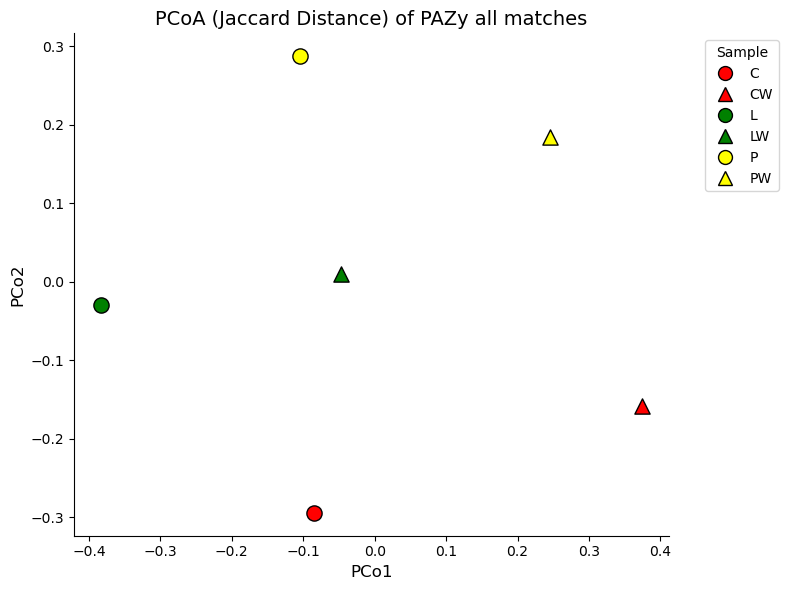

In [21]:
# Step 1: Create binary presence/absence matrix
presence_absence1 = (
    filtered_df
    .groupby(['treatments', 'Subject_ID'])
    .size()
    .unstack(fill_value=0)
)

# Step 2: Convert to binary (presence = 1)
presence_absence1 = presence_absence1.astype(bool).astype(int)

# Step 3: Jaccard distance matrix
jaccard_dist1 = pairwise_distances(presence_absence1.values, metric='jaccard')

# Step 4: Perform PCoA (classical MDS on distance matrix)
pcoa1 = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords1 = pcoa1.fit_transform(jaccard_dist1)

# Step 5: Create DataFrame for plotting
pcoa_df1 = pd.DataFrame(pcoa_coords1, columns=['PCo1', 'PCo2'], index=presence_absence1.index)
pcoa_df1['Category'] = pcoa_df1.index  # Same as Sample name

# Step 6: Define colors and markers
color_map = {
    'C': "red",  
    'CW': "red", 
    'L': "green", 
    'LW': "green",
    'P': "yellow",
    'PW': "yellow",
}

marker_map = {
    'C': 'o',
    'CW': '^',
    'L': 'o',
    'LW': '^',
    'P': 'o',
    'PW': '^',
}

# Step 7: Plot
plt.figure(figsize=(8, 6))

for category in pcoa_df1['Category'].unique():
    subset1 = pcoa_df1[pcoa_df1['Category'] == category]
    plt.scatter(subset1['PCo1'], subset1['PCo2'],
                color=color_map.get(category, 'gray'),
                marker=marker_map.get(category, 'o'),
                edgecolors='black',
                s=120,
                label=category)

# Aesthetics
plt.xlabel('PCo1', fontsize=12)
plt.ylabel('PCo2', fontsize=12)
plt.title('PCoA (Jaccard Distance) of PAZy all matches', fontsize=14)

# Clean look
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Custom legend
legend_elements = [Line2D([0], [0], marker=marker_map[cat], color='w',
                          markerfacecolor=color_map[cat],
                          markeredgecolor='black',
                          markersize=10, linestyle='None', label=cat)
                   for cat in color_map.keys()]

plt.legend(handles=legend_elements, title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [14]:
# Create the new column
combined_df["Length_over_Identity"] = combined_df["Alignment_Length"] / combined_df["Percentage_Identity"]

# Keep the row with the maximum Length/Identity for each Query_ID and treatment
filtered_df = combined_df.loc[combined_df.groupby(["Query_ID", "treatments"])["Length_over_Identity"].idxmax()].reset_index(drop=True)

print(filtered_df.head())

        Query_ID Subject_ID  Percentage_Identity  Alignment_Length  \
0  k99_1000665_4        101                 51.2               121   
1  k99_1002364_1       IS12                 50.6               154   
2  k99_1006987_1        202                 53.2                47   
3  k99_1009092_1    Est8_89                 50.7               229   
4  k99_1009330_1        102                 50.7               142   

   Mismatches  Gap_Openings  Query_Start  Query_End  Subject_Start  \
0          48             4          109        220              2   
1          74             2            1        153              1   
2          20             1           46         90             32   
3         107             2            4        230              3   
4          70             0            8        149             84   

   Subject_End       E-value  BitScore treatments  Length_over_Identity  
0          120  5.860000e-33     113.0          L              2.363281  
1         

In [15]:
# Save result
filtered_df.to_csv("filtered_best_hits.csv", sep=";", index=False)

In [16]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS

/hpcfs/home/ciencias_biologicas/mf.penav1/.miniforge/envs/python/lib/python3.12/site-packages/sklearn/metrics/pairwise.py:2361: DataConversionWarning: Data was converted to boolean for metric jaccard
  warnings.warn(msg, DataConversionWarning)


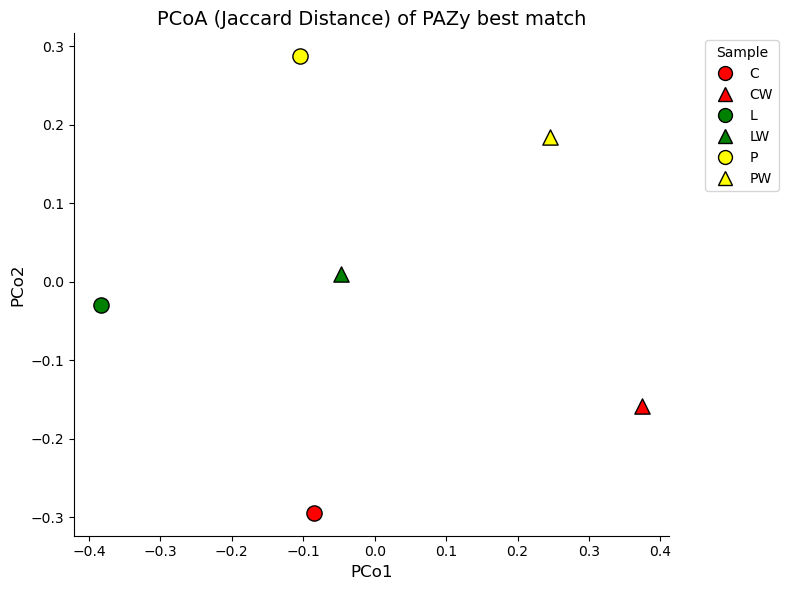

In [22]:
# Step 2: Create binary presence/absence matrix
presence_absence = (
    filtered_df
    .groupby(['treatments', 'Subject_ID'])
    .size()
    .unstack(fill_value=0)
)

# Step 3: Convert to binary (presence = 1)
presence_absence = presence_absence.astype(bool).astype(int)

# Step 4: Jaccard distance matrix
jaccard_dist = pairwise_distances(presence_absence.values, metric='jaccard')

# Step 5: Perform PCoA (classical MDS on distance matrix)
pcoa = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
pcoa_coords = pcoa.fit_transform(jaccard_dist)

# Step 6: Create DataFrame for plotting
pcoa_df = pd.DataFrame(pcoa_coords, columns=['PCo1', 'PCo2'], index=presence_absence.index)
pcoa_df['Category'] = pcoa_df.index  # Same as Sample name

# Step 7: Define colors and markers
color_map = {
    'C': "red",  
    'CW': "red", 
    'L': "green", 
    'LW': "green",
    'P': "yellow",
    'PW': "yellow",
}

marker_map = {
    'C': 'o',
    'CW': '^',
    'L': 'o',
    'LW': '^',
    'P': 'o',
    'PW': '^',
}

# Step 8: Plot
plt.figure(figsize=(8, 6))

for category in pcoa_df['Category'].unique():
    subset = pcoa_df[pcoa_df['Category'] == category]
    plt.scatter(subset['PCo1'], subset['PCo2'],
                color=color_map.get(category, 'gray'),
                marker=marker_map.get(category, 'o'),
                edgecolors='black',
                s=120,
                label=category)

# Aesthetics
plt.xlabel('PCo1', fontsize=12)
plt.ylabel('PCo2', fontsize=12)
plt.title('PCoA (Jaccard Distance) of PAZy best match', fontsize=14)

# Clean look
plt.grid(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Custom legend
legend_elements = [Line2D([0], [0], marker=marker_map[cat], color='w',
                          markerfacecolor=color_map[cat],
                          markeredgecolor='black',
                          markersize=10, linestyle='None', label=cat)
                   for cat in color_map.keys()]

plt.legend(handles=legend_elements, title='Sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()